In [1]:
import os
os.getcwd()

'/home/jovyan'

In [2]:
from pyspark.sql import Row
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pylab as P
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
sc = SparkContext("local", "First App")

spark = SparkSession.builder.master("local").appName("Word Count").config("spark.some.config.option", "some-value").getOrCreate()

get_ipython().magic('matplotlib inline')
plt.rcdefaults()

In [3]:
dataDir = '/home/jovyan/'
lines = sc.textFile(dataDir + "u.user")

In [4]:
splitLines = lines.map(lambda l: l.split("|"))
usersRDD = splitLines.map(lambda p: Row(id=p[0], age=int(p[1]), gender=p[2], occupation=p[3], zipcode=p[4]))
usersDF = spark.createDataFrame(usersRDD)
usersDF.createOrReplaceTempView("users")
usersDF.show()

+---+------+---+-------------+-------+
|age|gender| id|   occupation|zipcode|
+---+------+---+-------------+-------+
| 24|     M|  1|   technician|  85711|
| 53|     F|  2|        other|  94043|
| 23|     M|  3|       writer|  32067|
| 24|     M|  4|   technician|  43537|
| 33|     F|  5|        other|  15213|
| 42|     M|  6|    executive|  98101|
| 57|     M|  7|administrator|  91344|
| 36|     M|  8|administrator|  05201|
| 29|     M|  9|      student|  01002|
| 53|     M| 10|       lawyer|  90703|
| 39|     F| 11|        other|  30329|
| 28|     F| 12|        other|  06405|
| 47|     M| 13|     educator|  29206|
| 45|     M| 14|    scientist|  55106|
| 49|     F| 15|     educator|  97301|
| 21|     M| 16|entertainment|  10309|
| 30|     M| 17|   programmer|  06355|
| 35|     F| 18|        other|  37212|
| 40|     M| 19|    librarian|  02138|
| 42|     F| 20|    homemaker|  95660|
+---+------+---+-------------+-------+
only showing top 20 rows



In [5]:
ageDF = spark.sql("SELECT age FROM users")
ageList = ageDF.rdd.map(lambda p: p.age).collect()
ageDF.describe().show()

+-------+-----------------+
|summary|              age|
+-------+-----------------+
|  count|              943|
|   mean|34.05196182396607|
| stddev|12.19273973305903|
|    min|                7|
|    max|               73|
+-------+-----------------+



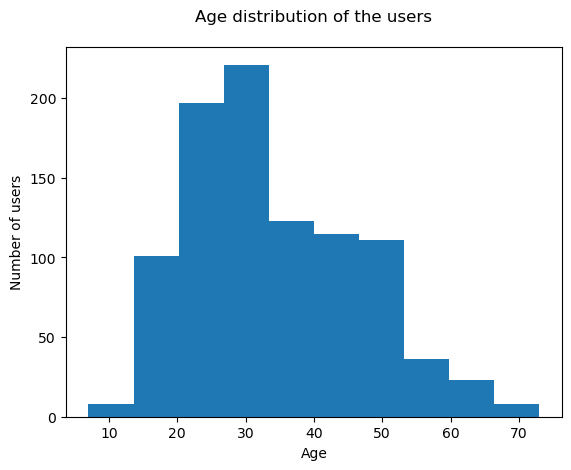

In [6]:
plt.hist(ageList)
plt.title("Age distribution of the users\n")
plt.xlabel("Age")
plt.ylabel("Number of users")
plt.show(block=False)

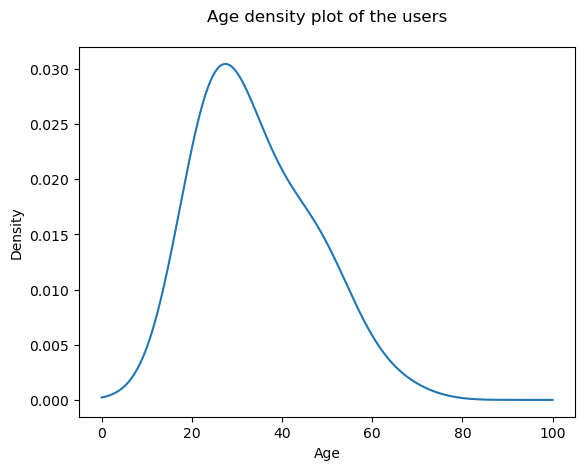

In [7]:
from scipy.stats import gaussian_kde
density = gaussian_kde(ageList)
xAxisValues = np.linspace(0,100,1000) # Use the range of ages from 0 to 100 and the number of data points
density.covariance_factor = lambda : .5
density._compute_covariance()
plt.title("Age density plot of the users\n")
plt.xlabel("Age")
plt.ylabel("Density")
plt.plot(xAxisValues, density(xAxisValues))
plt.show(block=False)

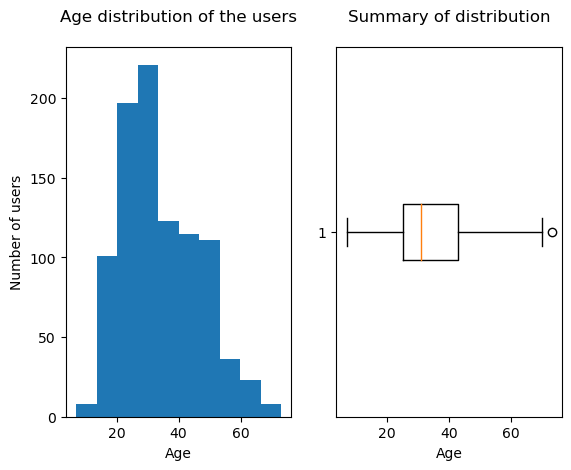

In [8]:
plt.subplot(121)
plt.hist(ageList)
plt.title("Age distribution of the users\n")
plt.xlabel("Age")
plt.ylabel("Number of users")
plt.subplot(122)
plt.title("Summary of distribution\n")
plt.xlabel("Age")
plt.boxplot(ageList, vert=False)
plt.show(block=False)

In [9]:

occupationsTop10 = spark.sql("SELECT occupation, count(occupation) as usercount FROM users GROUP BY occupation ORDER BY usercount DESC LIMIT 10")
occupationsTop10.show()

+-------------+---------+
|   occupation|usercount|
+-------------+---------+
|      student|      196|
|        other|      105|
|     educator|       95|
|administrator|       79|
|     engineer|       67|
|   programmer|       66|
|    librarian|       51|
|       writer|       45|
|    executive|       32|
|    scientist|       31|
+-------------+---------+



In [10]:
occupationsTop10Tuple = occupationsTop10.rdd.map(lambda p: (p.occupation,p.usercount)).collect()
occupationsTop10List, countTop10List = zip(*occupationsTop10Tuple)
occupationsTop10Tuple

[('student', 196),
 ('other', 105),
 ('educator', 95),
 ('administrator', 79),
 ('engineer', 67),
 ('programmer', 66),
 ('librarian', 51),
 ('writer', 45),
 ('executive', 32),
 ('scientist', 31)]

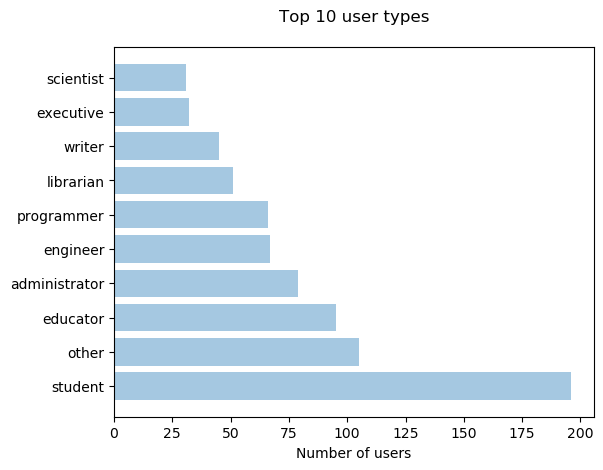

In [11]:
y_pos = np.arange(len(occupationsTop10List))
plt.barh(y_pos, countTop10List, align='center', alpha=0.4)
plt.yticks(y_pos, occupationsTop10List)
plt.xlabel('Number of users')
plt.title('Top 10 user types\n')
plt.gcf().subplots_adjust(left=0.15)
plt.show(block=False)

In [12]:
occupationsGender = spark.sql("SELECT occupation, gender FROM users")
occupationsGender.show()

+-------------+------+
|   occupation|gender|
+-------------+------+
|   technician|     M|
|        other|     F|
|       writer|     M|
|   technician|     M|
|        other|     F|
|    executive|     M|
|administrator|     M|
|administrator|     M|
|      student|     M|
|       lawyer|     M|
|        other|     F|
|        other|     F|
|     educator|     M|
|    scientist|     M|
|     educator|     F|
|entertainment|     M|
|   programmer|     M|
|        other|     F|
|    librarian|     M|
|    homemaker|     F|
+-------------+------+
only showing top 20 rows



In [13]:

occCrossTab = occupationsGender.stat.crosstab("occupation", "gender")
occCrossTab.show()

+-----------------+---+---+
|occupation_gender|  F|  M|
+-----------------+---+---+
|        scientist|  3| 28|
|          student| 60|136|
|           writer| 19| 26|
|         salesman|  3|  9|
|          retired|  1| 13|
|    administrator| 36| 43|
|       programmer|  6| 60|
|           doctor|  0|  7|
|        homemaker|  6|  1|
|        executive|  3| 29|
|         engineer|  2| 65|
|    entertainment|  2| 16|
|        marketing| 10| 16|
|       technician|  1| 26|
|           artist| 13| 15|
|        librarian| 29| 22|
|           lawyer|  2| 10|
|         educator| 26| 69|
|       healthcare| 11|  5|
|             none|  4|  5|
+-----------------+---+---+
only showing top 20 rows



In [14]:
occCrossTab.describe('M', 'F').show()

+-------+------------------+------------------+
|summary|                 M|                 F|
+-------+------------------+------------------+
|  count|                21|                21|
|   mean|31.904761904761905|              13.0|
| stddev|  32.3757698934014|15.874507866387544|
|    min|                 1|                 0|
|    max|               136|                60|
+-------+------------------+------------------+



In [15]:
occCrossTab.stat.cov('M', 'F')

381.15

In [16]:
occCrossTab.stat.corr('M', 'F')

0.741609951731364

In [17]:
occupationsCrossTuple = occCrossTab.rdd.map(lambda p: (p.occupation_gender,p.M, p.F)).collect()
occList, mList, fList = zip(*occupationsCrossTuple)

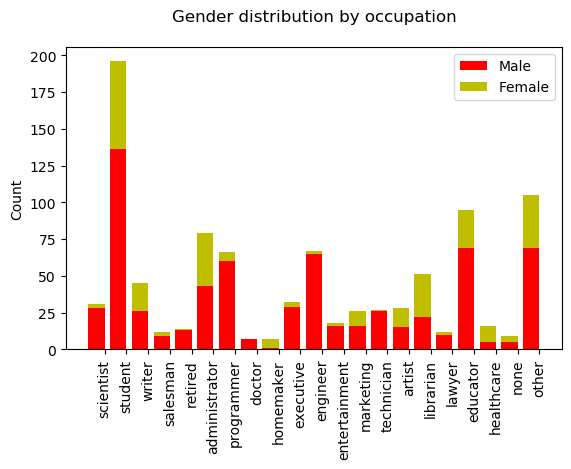

In [18]:
N = len(occList)
ind = np.arange(N)    # the x locations for the groups
width = 0.75          # the width of the bars: can also be len(x) sequence
p1 = plt.bar(ind, mList, width, color='r')
p2 = plt.bar(ind, fList, width, color='y', bottom=mList)
plt.ylabel('Count')
plt.title('Gender distribution by occupation\n')
plt.xticks(ind + width/2., occList, rotation=90)
plt.legend((p1[0], p2[0]), ('Male', 'Female'))
plt.gcf().subplots_adjust(bottom=0.25)
plt.show(block=False)

In [19]:
occupationsBottom10 = spark.sql("SELECT occupation, count(occupation) as usercount FROM users GROUP BY occupation ORDER BY usercount LIMIT 10")
occupationsBottom10.show()

+-------------+---------+
|   occupation|usercount|
+-------------+---------+
|       doctor|        7|
|    homemaker|        7|
|         none|        9|
|     salesman|       12|
|       lawyer|       12|
|      retired|       14|
|   healthcare|       16|
|entertainment|       18|
|    marketing|       26|
|   technician|       27|
+-------------+---------+



In [20]:
occupationsBottom10Tuple = occupationsBottom10.rdd.map(lambda p: (p.occupation,p.usercount)).collect()
occupationsBottom10List, countBottom10List = zip(*occupationsBottom10Tuple)

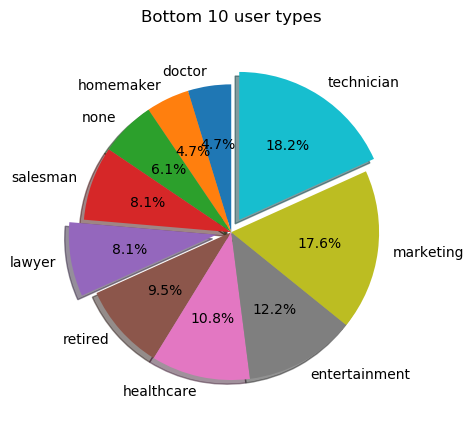

In [21]:
# Bottom 10 occupations in terms of the number of users having that occupation who have rated movies
explode = (0, 0, 0, 0,0.1,0,0,0,0,0.1)  
plt.pie(countBottom10List, explode=explode, labels=occupationsBottom10List, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Bottom 10 user types\n')
plt.show(block=False)

In [22]:
zipTop10 = spark.sql("SELECT zipcode, count(zipcode) as usercount FROM users GROUP BY zipcode ORDER BY usercount DESC LIMIT 10")
zipTop10.show()

+-------+---------+
|zipcode|usercount|
+-------+---------+
|  55414|        9|
|  55105|        6|
|  20009|        5|
|  10003|        5|
|  55337|        5|
|  27514|        4|
|  55408|        4|
|  55454|        4|
|  94043|        3|
|  55106|        3|
+-------+---------+



In [23]:
zipTop10Tuple = zipTop10.rdd.map(lambda p: (p.zipcode,p.usercount)).collect()
zipTop10List, countTop10List = zip(*zipTop10Tuple)

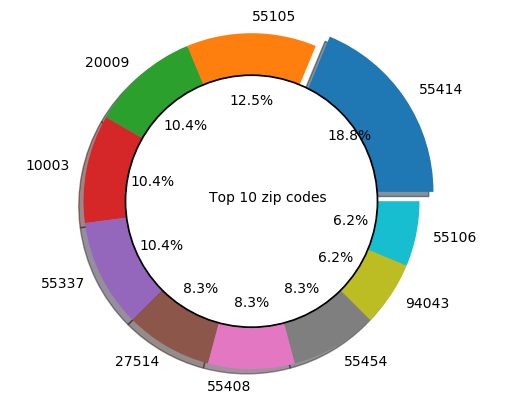

In [24]:
# Top 10 zipcodes in terms of the number of users living in that zipcode who have rated movies
explode = (0.1, 0, 0, 0,0,0,0,0,0,0)  # explode a slice if required
plt.pie(countTop10List, explode=explode, labels=zipTop10List, autopct='%1.1f%%', shadow=True)
#draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=1.25)
plt.gcf().gca().add_artist(centre_circle)
# The aspect ratio is to be made equal. This is to make sure that pie chart is coming perfectly as a circle.
plt.axis('equal')
plt.text(- 0.25,0,'Top 10 zip codes')
plt.show(block=False)

In [25]:

ages = spark.sql("SELECT occupation, age FROM users WHERE occupation ='administrator' ORDER BY age")
adminAges = ages.rdd.map(lambda p: p.age).collect()
ages.describe().show()

+-------+-------------+------------------+
|summary|   occupation|               age|
+-------+-------------+------------------+
|  count|           79|                79|
|   mean|         null| 38.74683544303797|
| stddev|         null|11.123396864533209|
|    min|administrator|                21|
|    max|administrator|                70|
+-------+-------------+------------------+



In [26]:

ages = spark.sql("SELECT occupation, age FROM users WHERE occupation ='engineer' ORDER BY age")
engAges = ages.rdd.map(lambda p: p.age).collect()
ages.describe().show()

+-------+----------+------------------+
|summary|occupation|               age|
+-------+----------+------------------+
|  count|        67|                67|
|   mean|      null| 36.38805970149254|
| stddev|      null|11.199235936979779|
|    min|  engineer|                22|
|    max|  engineer|                70|
+-------+----------+------------------+



In [27]:
ages = spark.sql("SELECT occupation, age FROM users WHERE occupation ='programmer' ORDER BY age")
progAges = ages.rdd.map(lambda p: p.age).collect()
ages.describe().show()

+-------+----------+------------------+
|summary|occupation|               age|
+-------+----------+------------------+
|  count|        66|                66|
|   mean|      null|33.121212121212125|
| stddev|      null| 9.624512217833972|
|    min|programmer|                20|
|    max|programmer|                63|
+-------+----------+------------------+



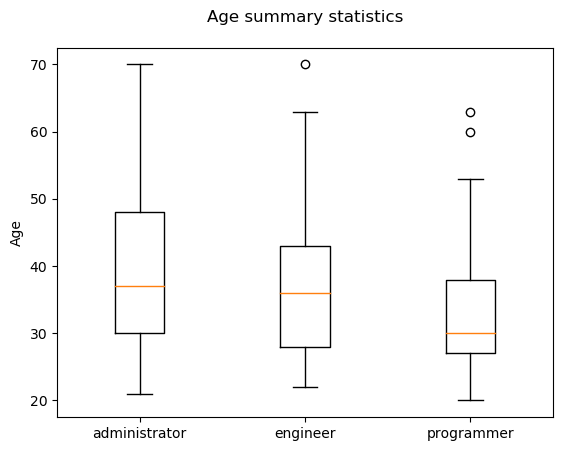

In [28]:
# Box plots of the ages by profession
boxPlotAges = [adminAges, engAges, progAges]
boxPlotLabels = ['administrator','engineer', 'programmer' ]
x = np.arange(len(boxPlotLabels))
plt.figure()
plt.boxplot(boxPlotAges)
plt.title('Age summary statistics\n')
plt.ylabel("Age")
plt.xticks(x + 1, boxPlotLabels, rotation=0)
plt.show(block=False)

In [29]:
movieLines = sc.textFile(dataDir + "u.item")
splitMovieLines = movieLines.map(lambda l: l.split("|"))
moviesRDD = splitMovieLines.map(lambda p: Row(id=p[0], title=p[1], releaseDate=p[2], videoReleaseDate=p[3], url=p[4], unknown=int(p[5]),action=int(p[6]),adventure=int(p[7]),animation=int(p[8]),childrens=int(p[9]),comedy=int(p[10]),crime=int(p[11]),documentary=int(p[12]),drama=int(p[13]),fantasy=int(p[14]),filmNoir=int(p[15]),horror=int(p[16]),musical=int(p[17]),mystery=int(p[18]),romance=int(p[19]),sciFi=int(p[20]),thriller=int(p[21]),war=int(p[22]),western=int(p[23])))
moviesDF = spark.createDataFrame(moviesRDD)
moviesDF.createOrReplaceTempView("movies")

In [30]:
genreDF = spark.sql("SELECT sum(unknown) as unknown, sum(action) as action,sum(adventure) as adventure,sum(animation) as animation, sum(childrens) as childrens,sum(comedy) as comedy,sum(crime) as crime,sum(documentary) as documentary,sum(drama) as drama,sum(fantasy) as fantasy,sum(filmNoir) as filmNoir,sum(horror) as horror,sum(musical) as musical,sum(mystery) as mystery,sum(romance) as romance,sum(sciFi) as sciFi,sum(thriller) as thriller,sum(war) as war,sum(western) as western FROM movies")
genreList = genreDF.collect()
genreDict = genreList[0].asDict()
labelValues = list(genreDict.keys())
countList = list(genreDict.values())
genreDict

{'unknown': 2,
 'action': 251,
 'adventure': 135,
 'animation': 42,
 'childrens': 122,
 'comedy': 505,
 'crime': 109,
 'documentary': 50,
 'drama': 725,
 'fantasy': 22,
 'filmNoir': 24,
 'horror': 92,
 'musical': 56,
 'mystery': 61,
 'romance': 247,
 'sciFi': 101,
 'thriller': 251,
 'war': 71,
 'western': 27}

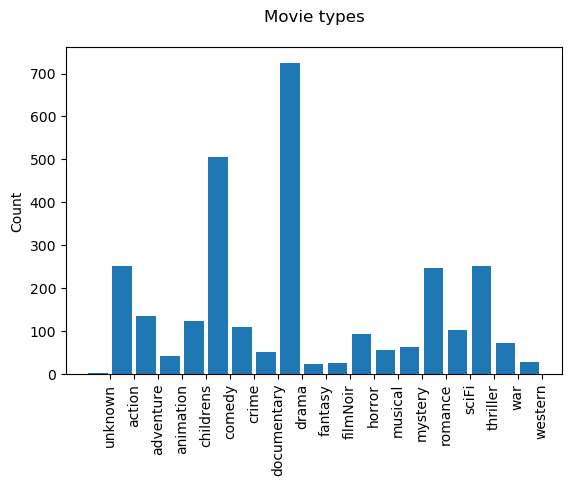

In [31]:
# http://opentechschool.github.io/python-data-intro/core/charts.html
# Movie types and the counts
x = np.arange(len(labelValues))
plt.title('Movie types\n')
plt.ylabel("Count")
plt.bar(x, countList)
plt.xticks(x + 0.5, labelValues, rotation=90)
plt.gcf().subplots_adjust(bottom=0.20)
plt.show(block=False)

In [33]:
yearDF = spark.sql("SELECT substring(releaseDate,8,4) as releaseYear, count(*) as movieCount FROM movies GROUP BY substring(releaseDate,8,4) ORDER BY movieCount DESC LIMIT 10")
yearDF.show()
yearMovieCountTuple = yearDF.rdd.map(lambda p: (int(p.releaseYear),p.movieCount)).collect()
yearList,movieCountList = zip(*yearMovieCountTuple)
countArea = yearDF.rdd.map(lambda p: np.pi * (p.movieCount/15)**2).collect()

+-----------+----------+
|releaseYear|movieCount|
+-----------+----------+
|       1996|       355|
|       1997|       286|
|       1995|       219|
|       1994|       214|
|       1993|       126|
|       1998|        65|
|       1992|        37|
|       1990|        24|
|       1991|        22|
|       1989|        15|
+-----------+----------+



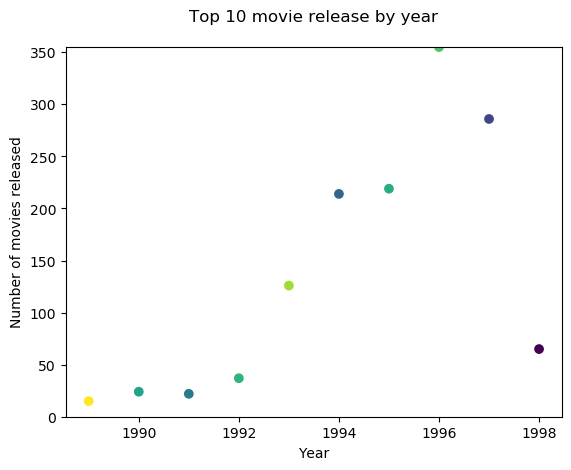

In [34]:
# Top 10 years where the most number of movies have been released
plt.title('Top 10 movie release by year\n')
plt.xlabel("Year")
plt.ylabel("Number of movies released")
plt.ylim([0,max(movieCountList)])
colors = np.random.rand(10)
plt.scatter(yearList, movieCountList,c=colors)
plt.show(block=False)

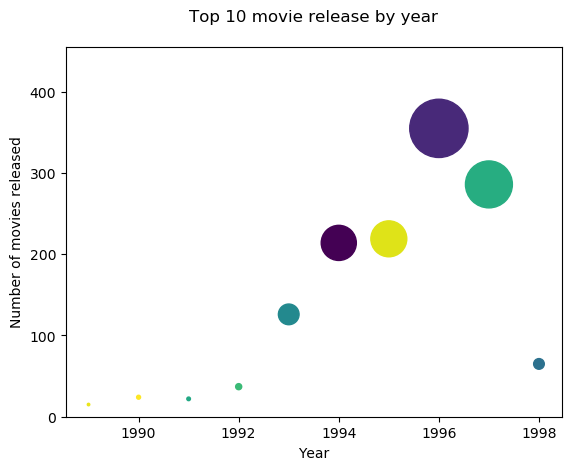

In [35]:
# Top 10 years where the most number of movies have been released
plt.title('Top 10 movie release by year\n')
plt.xlabel("Year")
plt.ylabel("Number of movies released")
plt.ylim([0,max(movieCountList) + 100])
colors = np.random.rand(10)
plt.scatter(yearList, movieCountList,c=colors, s=countArea)
plt.show(block=False)

In [36]:
yearActionDF = spark.sql("SELECT substring(releaseDate,8,4) as actionReleaseYear, count(*) as actionMovieCount FROM movies WHERE action = 1 GROUP BY substring(releaseDate,8,4) ORDER BY actionReleaseYear DESC LIMIT 10")
yearActionDF.show()
yearActionDF.createOrReplaceTempView("action")

+-----------------+----------------+
|actionReleaseYear|actionMovieCount|
+-----------------+----------------+
|             1998|              12|
|             1997|              46|
|             1996|              44|
|             1995|              40|
|             1994|              30|
|             1993|              20|
|             1992|               8|
|             1991|               2|
|             1990|               7|
|             1989|               6|
+-----------------+----------------+



In [37]:

yearDramaDF = spark.sql("SELECT substring(releaseDate,8,4) as dramaReleaseYear, count(*) as dramaMovieCount FROM movies WHERE drama = 1 GROUP BY substring(releaseDate,8,4) ORDER BY dramaReleaseYear DESC LIMIT 10")
yearDramaDF.show()
yearDramaDF.createOrReplaceTempView("drama")

+----------------+---------------+
|dramaReleaseYear|dramaMovieCount|
+----------------+---------------+
|            1998|             33|
|            1997|            113|
|            1996|            170|
|            1995|             89|
|            1994|             97|
|            1993|             64|
|            1992|             14|
|            1991|             11|
|            1990|             12|
|            1989|              8|
+----------------+---------------+



In [38]:
yearCombinedDF = spark.sql("SELECT a.actionReleaseYear as releaseYear, a.actionMovieCount, d.dramaMovieCount FROM action a, drama d WHERE a.actionReleaseYear = d.dramaReleaseYear ORDER BY a.actionReleaseYear DESC LIMIT 10")
yearCombinedDF.show()

+-----------+----------------+---------------+
|releaseYear|actionMovieCount|dramaMovieCount|
+-----------+----------------+---------------+
|       1998|              12|             33|
|       1997|              46|            113|
|       1996|              44|            170|
|       1995|              40|             89|
|       1994|              30|             97|
|       1993|              20|             64|
|       1992|               8|             14|
|       1991|               2|             11|
|       1990|               7|             12|
|       1989|               6|              8|
+-----------+----------------+---------------+



In [39]:

yearMovieCountTuple = yearCombinedDF.rdd.map(lambda p: (p.releaseYear,p.actionMovieCount, p.dramaMovieCount)).collect()
yearList,actionMovieCountList,dramaMovieCountList = zip(*yearMovieCountTuple)

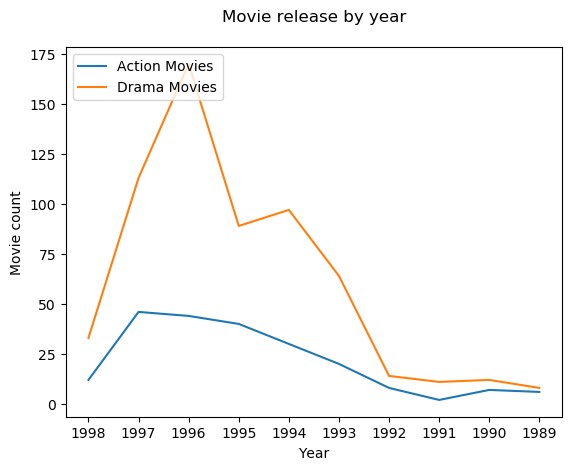

In [41]:
plt.title("Movie release by year\n")
plt.xlabel("Year")
plt.ylabel("Movie count")
line_action, = plt.plot(yearList, actionMovieCountList)
line_drama, = plt.plot(yearList, dramaMovieCountList)
plt.legend([line_action, line_drama], ['Action Movies', 'Drama Movies'],loc='upper left')
plt.gca().get_xaxis().get_major_formatter()
plt.show(block=False)